In [1]:
# !pip install combat

In [2]:
# Adjust this import to wherever your pyComBat lives. Common options:
# from combat.pycombat import pycombat
# from pycombat import pycombat
from combat.pycombat import pycombat  

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [3]:
# 1) Toy data generator
def generate_toy_data(
    n_genes=1000,
    n_samples_per_batch=10,
    n_batches=2,
    batch_shift=0.5,
    batch_scale=0.1,
    n_classes=2,
    seed=0
):
    np.random.seed(seed)
    total_samples = n_samples_per_batch * n_batches
    base = np.random.normal(0, 1, (n_genes, total_samples))

    # Biological class effects
    class_labels = np.random.choice(n_classes, total_samples)
    class_effect = np.random.normal(1.0, 0.2, (n_genes, n_classes))
    for c in range(n_classes):
        base[:, class_labels == c] += class_effect[:, [c]]

    # Batch effects (subtle shift + scale)
    batch_labels = np.repeat(np.arange(n_batches), n_samples_per_batch)
    batch_means  = np.random.normal(0, batch_shift, (n_genes, n_batches))
    batch_scales = np.random.normal(1.0, batch_scale, (n_genes, n_batches))
    for b in range(n_batches):
        idx = np.where(batch_labels == b)[0]
        base[:, idx] = base[:, idx] * batch_scales[:, [b]] + batch_means[:, [b]]

    data = pd.DataFrame(
        base,
        index=[f"Gene{i}" for i in range(n_genes)],
        columns=[f"S{j}" for j in range(total_samples)]
    )
    return data, batch_labels, class_labels


In [4]:
data, batch_labels, class_labels = generate_toy_data()
data.head()

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19
Gene0,1.195863,-0.117376,0.504648,1.861571,1.460204,-1.751299,0.473847,-0.863364,-0.811612,-0.259214,1.883035,3.382807,2.589286,1.857431,2.389198,2.100099,3.428371,1.646287,2.239481,0.740502
Gene1,-2.018342,1.434598,1.659094,-0.051748,3.155593,-0.848436,0.787298,0.500964,2.332523,2.264987,0.726258,0.927253,-0.212675,-1.196880,0.305824,0.727520,1.694555,1.701790,0.270333,0.314526
Gene2,-0.649527,-0.953055,-1.220265,2.193511,-0.103247,-0.079657,-0.796956,1.055047,-1.177264,0.130687,0.218173,1.537280,0.613855,-0.075162,1.157938,1.579897,1.207717,1.498065,0.534433,0.766161
Gene3,-0.329676,-0.187444,-0.624376,-1.503973,0.329812,-0.068939,-1.411418,0.763869,-0.555888,0.368122,1.357522,0.847180,1.706457,-0.312628,0.939116,0.155115,-0.003052,0.104693,0.332007,0.785254
Gene4,-0.038965,2.131814,1.686524,-0.361967,2.732909,3.093305,2.416235,0.969186,0.057629,2.232287,0.512429,1.886404,1.029228,1.678648,1.201250,1.450389,0.862068,2.409466,1.007315,1.192955


In [5]:
## custom combat from o4-mini-high
import numpy as np
import pandas as pd
from typing import List, Any

def combat(
    data: pd.DataFrame,
    batch: List[Any]
) -> pd.DataFrame:
    """
    Parametric empirical Bayes batch correction (ComBat) as in Johnson et al. 2007.

    Parameters
    ----------
    data : pd.DataFrame
        Gene expression matrix (rows = genes, columns = samples).
    batch : list-like
        Batch labels for each sample (length must equal number of columns in `data`).

    Returns
    -------
    pd.DataFrame
        Batch-corrected data, same shape as input.
    """
    # --- 1. Preparatory bookkeeping ---
    samples = list(data.columns)
    genes = data.index
    batch = pd.Series(batch, index=samples)
    batches = batch.unique()
    n_batches = len(batches)
    # number of samples per batch
    n_i = batch.value_counts().to_dict()  # batch -> count

    # --- 2. Fit intercept-only model Y_ijg = α_g + γ_ig + ε_ijg ---
    #   α̂_g = overall mean for each gene
    alpha_hat = data.mean(axis=1)

    #   γ̂_ig = (mean within batch i) − α̂_g
    #   and center each sample: Y_ijg - α̂_g
    Y_centered = data.sub(alpha_hat, axis=0)
    gamma_hat = pd.DataFrame(index=genes, columns=batches, dtype=float)
    for b in batches:
        idx = batch[batch == b].index
        gamma_hat[b] = Y_centered[idx].mean(axis=1)

    #   residuals R_ijg = Y_ijg − α̂_g − γ̂_ig
    residuals = pd.DataFrame(index=genes, columns=samples, dtype=float)
    for samp in samples:
        b = batch[samp]
        residuals[samp] = data[samp] - alpha_hat - gamma_hat[b]

    #   σ̂_g = sqrt[ Σ_j R_ijg^2  / N ]
    N = len(samples)
    sigma_hat = np.sqrt((residuals**2).sum(axis=1) / N)

    # --- 3. Standardize data: Z_ijg = R_ijg / σ̂_g ---
    Z = residuals.div(sigma_hat, axis=0)

    # --- 4. Gene-wise estimates on Z: γ̂_z, δ̂² ---
    gamma_hat_z = pd.DataFrame(index=genes, columns=batches, dtype=float)
    delta_hat2 = pd.DataFrame(index=genes, columns=batches, dtype=float)
    for b in batches:
        idx = batch[batch == b].index
        gamma_hat_z[b] = Z[idx].mean(axis=1)
        # Use denominator = n_i
        delta_hat2[b] = ((Z[idx].sub(gamma_hat_z[b], axis=0))**2).sum(axis=1) / n_i[b]

    # --- 5. Estimate batch-specific priors by method of moments ---
    #   γ_i ∼ N(γ_i, τ_i²)
    gamma_bar = gamma_hat_z.mean(axis=0)            # shape (n_batches,)
    tau2      = gamma_hat_z.var(axis=0, ddof=1)     # shape (n_batches,)

    #   δ²_ig ∼ InvGamma(λ_i, θ_i)
    m  = delta_hat2.mean(axis=0)
    s2 = delta_hat2.var(axis=0, ddof=1)
    lambda_ = 2.0 + (m**2 / s2)
    theta   = m * (lambda_ - 1.0)

    # --- 6. Posterior (“shrunken”) estimates (equation (3.1)) ---
    gamma_star   = pd.DataFrame(index=genes, columns=batches, dtype=float)
    delta_star2  = pd.DataFrame(index=genes, columns=batches, dtype=float)
    delta_star   = pd.DataFrame(index=genes, columns=batches, dtype=float)

    for b in batches:
        ni = n_i[b]
        # (a) additive:
        numer = ni * tau2[b] * gamma_hat_z[b] + delta_hat2[b] * gamma_bar[b]
        denom = ni * tau2[b] + delta_hat2[b]
        gamma_star[b] = numer / denom

        # (b) multiplicative:
        idx = batch[batch == b].index
        resid_ss = ((Z[idx].sub(gamma_star[b], axis=0))**2).sum(axis=1)
        delta_star2[b] = (theta[b] + 0.5 * resid_ss) / ( (ni/2.0) + lambda_[b] - 1.0 )
        delta_star[b]  = np.sqrt(delta_star2[b])

    # --- 7. Adjust the data and back-transform ---
    #   Z_adj_ijg = (Z_ijg − γ*_ig) / δ*_ig
    #   Y_adj_ijg = Z_adj_ijg * σ̂_g + α̂_g
    corrected = pd.DataFrame(index=genes, columns=samples, dtype=float)
    for samp in samples:
        b = batch[samp]
        z = (data[samp] - alpha_hat - gamma_hat[b]) / sigma_hat
        z_adj = (z - gamma_star[b]) / delta_star[b]
        corrected[samp] = (z_adj * sigma_hat) + alpha_hat

    return corrected


## now gemini

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def combat_gemini(data: pd.DataFrame, batch: list, covariates: pd.DataFrame = None):
    """
    Adjusts for batch effects in omics data using the Empirical Bayes method.

    This implementation strictly follows the mathematical description from:
    Johnson, W. E., Li, C., & Rabinovic, A. (2007). Adjusting batch effects in
    microarray expression data using empirical Bayes methods. Biostatistics, 8(1), 118-127.

    Args:
        data (pd.DataFrame): The expression dataframe, with genes as rows and samples as columns.
        batch (list): A list or pandas Series indicating the batch for each sample, in the same order as the columns of `data`.
        covariates (pd.DataFrame, optional): A dataframe of known biological covariates, with samples as rows.
                                            If None, only an intercept is used as the biological model. Defaults to None.

    Returns:
        pd.DataFrame: The batch-corrected data in the same shape as the input data.
    """
    # --- Initial Setup ---
    # Transpose data to have genes as columns for easier modeling (samples x genes)
    data_matrix = data.T.to_numpy()
    genes = data.index
    samples = data.columns
    
    # Format batch information
    batch_series = pd.Series(batch, index=samples)
    unique_batches = batch_series.unique().tolist()
    n_batch = len(unique_batches)
    n_samples, n_genes = data_matrix.shape
    batch_sample_counts = batch_series.value_counts()

    # --- Step 1: Data Standardization  ---

    # Create the design matrix for biological covariates [cite: 125]
    if covariates is None:
        bio_covar_design = np.ones((n_samples, 1)) # Intercept only
    else:
        # Add intercept to the provided covariates
        bio_covar_design = sm.add_constant(covariates.loc[samples].to_numpy())

    # Create the full design matrix including batch dummies
    batch_dummies = pd.get_dummies(batch_series).loc[samples]
    full_design = np.column_stack((bio_covar_design, batch_dummies.to_numpy()))
    
    # Fit the linear model Y ~ bio_covars + batch for each gene [cite: 156]
    ols_coeffs = np.linalg.pinv(full_design.T @ full_design) @ full_design.T @ data_matrix
    
    # Calculate the portion of expression explained by biological covariates [cite: 158]
    n_bio_covars = bio_covar_design.shape[1]
    bio_coeffs = ols_coeffs[:n_bio_covars, :]
    biological_signal = bio_covar_design @ bio_coeffs

    # Estimate the error variance sigma_g^2 from the full model's residuals [cite: 157]
    residuals = data_matrix - full_design @ ols_coeffs
    sigma_g_sq = np.var(residuals, axis=0, ddof=0)
    sigma_g = np.sqrt(sigma_g_sq)

    # Standardize the data, removing the biological signal [cite: 158]
    # Z_ijg = (Y_ijg - hat(alpha_g) - X*hat(beta_g)) / hat(sigma_g)
    Z_ijg = (data_matrix - biological_signal) / np.where(sigma_g > 0, sigma_g, 1e-6)

    # --- Step 2: Empirical Bayes Parameter Estimation  ---
    
    # Calculate gene-wise sample means (gamma_hat) and variances (delta_hat^2) from standardized data Z
    gamma_hat = np.zeros((n_batch, n_genes))
    delta_hat_sq = np.zeros((n_batch, n_genes))
    
    for i, batch_name in enumerate(unique_batches):
        batch_mask = (batch_series == batch_name).to_numpy()
        gamma_hat[i, :] = np.mean(Z_ijg[batch_mask, :], axis=0)
        delta_hat_sq[i, :] = np.var(Z_ijg[batch_mask, :], axis=0, ddof=1)

    # Estimate prior hyperparameters for each batch using the method of moments [cite: 163]
    # Priors: gamma_ig ~ N(gamma_i, tau_i^2), delta_ig^2 ~ Inverse Gamma(lambda_i, theta_i) [cite: 162]
    gamma_i_bar = np.nanmean(gamma_hat, axis=1)
    tau_i_sq_bar = np.nanvar(gamma_hat, axis=1, ddof=1)
    
    lambda_i_bar = np.zeros(n_batch)
    theta_i_bar = np.zeros(n_batch)
    
    for i in range(n_batch):
        mean_var = np.nanmean(delta_hat_sq[i, :])
        var_var = np.nanvar(delta_hat_sq[i, :], ddof=1)
        lambda_i_bar[i] = (mean_var**2 / var_var) + 2 if var_var > 0 else 2
        theta_i_bar[i] = mean_var * (lambda_i_bar[i] - 1)

    # Find posterior estimates gamma* and delta*^2 iteratively for each batch [cite: 215]
    gamma_star = np.zeros_like(gamma_hat)
    delta_star_sq = np.zeros_like(delta_hat_sq)

    for i, batch_name in enumerate(unique_batches):
        n_i = batch_sample_counts[batch_name]
        
        # Slices and prior parameters for the current batch
        g_hat, d_hat_sq = gamma_hat[i, :], delta_hat_sq[i, :]
        g_bar, t_sq_bar = gamma_i_bar[i], tau_i_sq_bar[i]
        l_bar, th_bar = lambda_i_bar[i], theta_i_bar[i]
        
        # Initialize with sample variance
        delta_iter = np.nan_to_num(d_hat_sq, nan=1.0)
        
        # Solve for gamma* and delta*^2 iteratively
        for _ in range(100):
            # Update gamma* based on equation (3.1) [cite: 216]
            gamma_iter = (n_i * t_sq_bar * g_hat + delta_iter * g_bar) / (n_i * t_sq_bar + delta_iter)
            
            # Update delta*^2 based on equation (3.1) [cite: 217]
            batch_mask = (batch_series == batch_name).to_numpy()
            sum_sq_error = np.sum((Z_ijg[batch_mask, :] - gamma_iter)**2, axis=0)
            delta_iter = (th_bar + 0.5 * sum_sq_error) / (n_i / 2 + l_bar - 1)

        gamma_star[i, :] = gamma_iter
        delta_star_sq[i, :] = delta_iter

    # --- Step 3: Data Adjustment  ---
    
    # Calculate the adjusted data matrix based on equation (3.2) [cite: 231]
    adjusted_data_matrix = np.zeros_like(data_matrix)
    delta_star = np.sqrt(delta_star_sq)

    for i, batch_name in enumerate(unique_batches):
        batch_mask = (batch_series == batch_name).to_numpy()
        
        # Standardize data with EB parameters: (Z_ijg - gamma*_ig) / delta*_ig
        centered_z = Z_ijg[batch_mask, :] - gamma_star[i, :]
        scaled_z = centered_z / np.where(delta_star[i,:] > 0, delta_star[i,:], 1e-6)
        
        # Rescale by original sigma_g and add back the biological signal
        # Y*_ijg = (hat(sigma_g) * scaled_z) + (hat(alpha_g) + X*hat(beta_g))
        adjusted_batch_data = scaled_z * np.where(sigma_g > 0, sigma_g, 1e-6)
        adjusted_data_matrix[batch_mask, :] = adjusted_batch_data + biological_signal[batch_mask, :]
        
    # --- Finalize ---
    # Transpose back to Genes x Samples and create DataFrame
    adjusted_df = pd.DataFrame(adjusted_data_matrix.T, index=genes, columns=samples)
    
    return adjusted_df

# claude

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import digamma, polygamma
import warnings

def combat_claude(data, batch_labels, design_matrix=None):
    """
    Adjust batch effects in microarray expression data using empirical Bayes methods.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Expression data with genes as rows and samples as columns
    batch_labels : list or array-like
        Batch labels for each sample (same order as columns in data)
    design_matrix : pandas.DataFrame, optional
        Design matrix for covariates (samples as rows, covariates as columns)
        If None, only intercept is used
    
    Returns:
    --------
    pandas.DataFrame
        Batch-corrected expression data
    """
    
    # Convert to numpy arrays for computation
    Y = data.values.astype(float)
    batch_labels = np.array(batch_labels)
    
    # Get dimensions
    n_genes, n_samples = Y.shape
    
    # Get unique batches and create batch indicators
    batches = np.unique(batch_labels)
    n_batches = len(batches)
    
    # Create batch design matrix
    batch_design = np.zeros((n_samples, n_batches))
    for i, batch in enumerate(batches):
        batch_design[:, i] = (batch_labels == batch).astype(int)
    
    # Create full design matrix
    if design_matrix is None:
        # Only intercept
        X = np.ones((n_samples, 1))
    else:
        # Add intercept to design matrix
        X = np.column_stack([np.ones(n_samples), design_matrix.values])
    
    # Combine design matrix with batch indicators
    # Full design: [intercept/covariates, batch_indicators]
    full_design = np.column_stack([X, batch_design])
    
    # Step 1: Fit model and get initial estimates
    print("Step 1: Fitting linear model...")
    
    # Fit linear model for each gene: Y = X*beta + batch_effects + error
    alpha_hat = np.zeros(n_genes)
    beta_hat = np.zeros((n_genes, X.shape[1]))
    gamma_hat = np.zeros((n_genes, n_batches))
    sigma_hat = np.zeros(n_genes)
    
    for g in range(n_genes):
        # Fit: y = X*beta + batch_effects
        # Constraint: sum(n_i * gamma_i) = 0 for identifiability
        
        # Use least squares with constraint
        y = Y[g, :]
        
        # Fit without constraint first
        try:
            coeffs = np.linalg.lstsq(full_design, y, rcond=None)[0]
        except np.linalg.LinAlgError:
            # If singular, use pseudo-inverse
            coeffs = np.linalg.pinv(full_design) @ y
        
        # Extract components
        if X.shape[1] == 1:  # Only intercept
            alpha_hat[g] = coeffs[0]
            beta_hat[g, :] = coeffs[:X.shape[1]]
        else:
            alpha_hat[g] = coeffs[0]
            beta_hat[g, :] = coeffs[:X.shape[1]]
        
        # Extract batch effects and apply constraint
        batch_effects = coeffs[X.shape[1]:]
        
        # Apply constraint: sum(n_i * gamma_i) = 0
        batch_sizes = np.array([np.sum(batch_labels == batch) for batch in batches])
        weighted_mean = np.sum(batch_effects * batch_sizes) / np.sum(batch_sizes)
        gamma_hat[g, :] = batch_effects - weighted_mean
        
        # Calculate residual variance
        fitted = X @ beta_hat[g, :] + batch_design @ gamma_hat[g, :]
        residuals = y - fitted
        sigma_hat[g] = np.sqrt(np.sum(residuals**2) / (n_samples - X.shape[1] - n_batches + 1))
    
    # Step 2: Standardize data
    print("Step 2: Standardizing data...")
    
    Z = np.zeros_like(Y)
    for g in range(n_genes):
        fitted_no_batch = X @ beta_hat[g, :] + alpha_hat[g]
        Z[g, :] = (Y[g, :] - fitted_no_batch) / sigma_hat[g]
    
    # Step 3: Estimate hyperparameters using method of moments
    print("Step 3: Estimating hyperparameters...")
    
    # For each batch, estimate hyperparameters
    gamma_bar = np.zeros(n_batches)  # mean of gamma priors
    tau_squared = np.zeros(n_batches)  # variance of gamma priors
    lambda_params = np.zeros(n_batches)  # shape parameter for inverse gamma
    theta_params = np.zeros(n_batches)  # scale parameter for inverse gamma
    
    for i, batch in enumerate(batches):
        batch_mask = batch_labels == batch
        batch_size = np.sum(batch_mask)
        
        # Extract batch-specific standardized residuals
        batch_residuals = Z[:, batch_mask] - gamma_hat[:, i:i+1]
        
        # Estimate gamma hyperparameters (method of moments)
        gamma_bar[i] = np.mean(gamma_hat[:, i])
        tau_squared[i] = np.var(gamma_hat[:, i])
        
        # Estimate delta hyperparameters
        # Calculate sample variances for each gene in this batch
        delta_squared_hat = np.zeros(n_genes)
        for g in range(n_genes):
            if batch_size > 1:
                delta_squared_hat[g] = np.var(batch_residuals[g, :], ddof=1)
            else:
                delta_squared_hat[g] = 1.0  # Default for single sample
        
        # Method of moments for inverse gamma
        mean_delta_sq = np.mean(delta_squared_hat)
        var_delta_sq = np.var(delta_squared_hat)
        
        if var_delta_sq > 0:
            # Inverse gamma: mean = theta/(lambda-1), var = theta^2/((lambda-1)^2*(lambda-2))
            lambda_params[i] = 2 * mean_delta_sq**2 / var_delta_sq + 2
            theta_params[i] = mean_delta_sq * (lambda_params[i] - 1)
        else:
            lambda_params[i] = 2.0
            theta_params[i] = 1.0
    
    # Step 4: Compute empirical Bayes estimates
    print("Step 4: Computing empirical Bayes estimates...")
    
    gamma_star = np.zeros_like(gamma_hat)
    delta_star = np.zeros_like(gamma_hat)
    
    for i, batch in enumerate(batches):
        batch_mask = batch_labels == batch
        batch_size = np.sum(batch_mask)
        
        for g in range(n_genes):
            # EB estimate of gamma (additive batch effect)
            # gamma_star = (n_i * tau_i^2 * gamma_hat + delta_star^2 * gamma_bar) / (n_i * tau_i^2 + delta_star^2)
            
            # First, get initial delta_star estimate
            batch_residuals = Z[g, batch_mask] - gamma_hat[g, i]
            if batch_size > 1:
                sum_sq_residuals = np.sum(batch_residuals**2)
            else:
                sum_sq_residuals = 0.0
            
            # EB estimate of delta^2 (multiplicative batch effect)
            delta_star_sq = (theta_params[i] + 0.5 * sum_sq_residuals) / (batch_size/2 + lambda_params[i] - 1)
            
            # EB estimate of gamma
            precision_gamma = batch_size * tau_squared[i] + delta_star_sq
            if precision_gamma > 0:
                gamma_star[g, i] = (batch_size * tau_squared[i] * gamma_hat[g, i] + delta_star_sq * gamma_bar[i]) / precision_gamma
            else:
                gamma_star[g, i] = gamma_hat[g, i]
            
            delta_star[g, i] = np.sqrt(delta_star_sq)
    
    # Step 5: Adjust the data
    print("Step 5: Adjusting data for batch effects...")
    
    Y_adjusted = np.zeros_like(Y)
    
    for g in range(n_genes):
        for j in range(n_samples):
            # Find which batch this sample belongs to
            batch_idx = np.where(batches == batch_labels[j])[0][0]
            
            # Apply the adjustment formula from equation after (3.1)
            # Y_adjusted = (sigma_g / delta_star) * (Z - gamma_star) + alpha_g + X*beta_g
            z_adjusted = (Z[g, j] - gamma_star[g, batch_idx]) / delta_star[g, batch_idx]
            Y_adjusted[g, j] = sigma_hat[g] * z_adjusted + alpha_hat[g] + X[j, :] @ beta_hat[g, :]
    
    # Convert back to DataFrame
    result = pd.DataFrame(Y_adjusted, index=data.index, columns=data.columns)
    
    print("Batch correction completed successfully!")
    return result


# Example usage and testing function
def test_combat():
    """Test the ComBat implementation with simulated data"""
    
    # Create simulated data with batch effects
    np.random.seed(42)
    n_genes = 100
    n_samples_per_batch = 5
    n_batches = 3
    
    # Generate true expression without batch effects
    true_expr = np.random.randn(n_genes, n_samples_per_batch * n_batches)
    
    # Add batch effects
    batch_labels = []
    data_with_batch = np.zeros_like(true_expr)
    
    for i in range(n_batches):
        start_idx = i * n_samples_per_batch
        end_idx = (i + 1) * n_samples_per_batch
        
        # Add batch-specific effects
        additive_effect = np.random.randn(n_genes, 1) * 0.5
        multiplicative_effect = np.random.lognormal(0, 0.1, (n_genes, 1))
        
        data_with_batch[:, start_idx:end_idx] = (true_expr[:, start_idx:end_idx] + additive_effect) * multiplicative_effect
        batch_labels.extend([f'Batch_{i+1}'] * n_samples_per_batch)
    
    # Create DataFrame
    gene_names = [f'Gene_{i+1}' for i in range(n_genes)]
    sample_names = [f'Sample_{i+1}' for i in range(n_samples_per_batch * n_batches)]
    
    data_df = pd.DataFrame(data_with_batch, index=gene_names, columns=sample_names)
    
    print("Original data shape:", data_df.shape)
    print("Batch labels:", batch_labels)
    
    # Apply ComBat correction
    corrected_data = combat_claude(data_df, batch_labels)
    
    print("Corrected data shape:", corrected_data.shape)
    print("Correction completed successfully!")
    
    return data_df, corrected_data, batch_labels

# Uncomment to test
# original, corrected, batches = test_combat()

# show all the corrections in PCA space

Step 1: Fitting linear model...
Step 2: Standardizing data...
Step 3: Estimating hyperparameters...
Step 4: Computing empirical Bayes estimates...
Step 5: Adjusting data for batch effects...
Batch correction completed successfully!
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


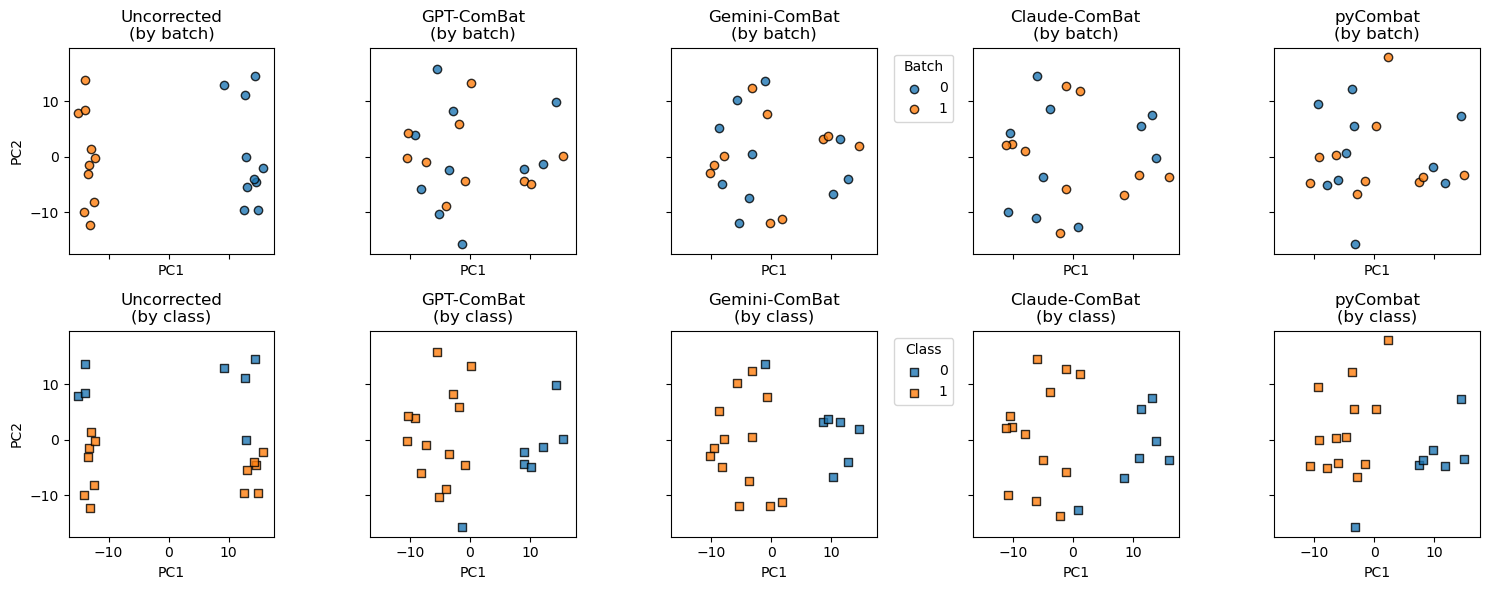

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## are all the LLMs the same? 
# --- Generate one example and plot in PCA space ---
data, batch_labels, class_labels = generate_toy_data(seed=13)

# Apply corrections
gpt_corr = combat(data, batch_labels)
g_corr = combat_gemini(data, batch_labels)
claude_corr = combat_claude(data, batch_labels)

pycombat_corr = pycombat(data, batch=batch_labels)


# original & corrected datasets
corrected = {
    "Uncorrected": data,
    "GPT-ComBat":   gpt_corr,
    "Gemini-ComBat": g_corr,
    "Claude-ComBat": claude_corr,
    "pyCombat":     pycombat_corr,
}

batch_labels = np.array(batch_labels)
class_labels = np.array(class_labels)
batches = np.unique(batch_labels)
classes = np.unique(class_labels)

n_cols = len(corrected)
fig, axes = plt.subplots(2, n_cols, figsize=(3*n_cols, 6), sharex=True, sharey=True)

for col, (name, df_mat) in enumerate(corrected.items()):
    # PCA on samples × genes
    X = df_mat.T.values
    pcs = PCA(n_components=2).fit_transform(X)
    pc_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=df_mat.columns)

    # top row: by batch
    ax = axes[0, col]
    for b in batches:
        mask = batch_labels == b
        ax.scatter(
            pc_df.loc[mask, "PC1"],
            pc_df.loc[mask, "PC2"],
            label=str(b),
            alpha=0.8,
            edgecolor="k"
        )
    ax.set_title(f"{name}\n(by batch)")
    if col == 0:
        ax.set_ylabel("PC2")
    ax.set_xlabel("PC1")
    if col == n_cols // 2:
        ax.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc="upper left")

    # bottom row: by class
    ax = axes[1, col]
    for c in classes:
        mask = class_labels == c
        ax.scatter(
            pc_df.loc[mask, "PC1"],
            pc_df.loc[mask, "PC2"],
            label=str(c),
            marker="s",
            alpha=0.8,
            edgecolor="k"
        )
    ax.set_title(f"{name}\n(by class)")
    if col == 0:
        ax.set_ylabel("PC2")
    ax.set_xlabel("PC1")
    if col == n_cols // 2:
        ax.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig('../plots/all-models-pca.svg', bbox_inches='tight')
plt.show()


In [9]:
%%capture

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

# -- helpers from above --
def compute_lisi(embedding, labels, k=5):
    n = embedding.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    _, idx = nbrs.kneighbors(embedding, return_distance=True)
    lisi = []
    for i in range(n):
        neigh = idx[i,1:]
        counts = np.bincount(labels[neigh], minlength=labels.max()+1)
        p = counts / counts.sum()
        lisi.append(1.0 / np.sum(p**2))
    return np.mean(lisi)

def classification_score(embedding, labels, random_state=0):
    clf = LogisticRegression(max_iter=200, solver='liblinear', random_state=random_state)
    cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    return cross_val_score(clf, embedding, labels, cv=cv).mean()

# -- methods mapping to a function that returns corrected DataFrame --
methods = {
    "Uncorrected": lambda data, batch: data,
    "GPT-ComBat":   lambda data, batch: combat(data, batch),
    "Gemini-ComBat":lambda data, batch: combat_gemini(data, batch),
    "Claude-ComBat":lambda data, batch: combat_claude(data, batch),
    "pyComBat":     lambda data, batch: pycombat(data, batch=batch),
}

# metrics we’ll compute
metric_names = [
    "ASW_class", "ASW_batch",
    "iLISI_batch", "cLISI_class",
    "CVacc_batch", "CVacc_class"
]

# initialize storage
results = {
    method: {met: [] for met in metric_names}
    for method in methods
}

# -- main loop --
for seed in range(100):
    # 1) generate toy data
    data, batch_labels, class_labels = generate_toy_data(seed=seed)
    batch_arr = np.array(batch_labels)
    class_arr = np.array(class_labels)

    # 2) for each method, correct → PCA → metrics
    for name, corr_fn in methods.items():
        mat = corr_fn(data, batch_labels)       # DataFrame (genes × samples)
        emb = PCA(n_components=2).fit_transform(mat.T.values)

        # silhouette on class & batch
        results[name]["ASW_class"].append( silhouette_score(emb, class_arr) )
        results[name]["ASW_batch"].append( silhouette_score(emb, batch_arr) )

        # LISI on class & batch
        results[name]["iLISI_batch"].append( compute_lisi(emb, batch_arr, k=5) )
        results[name]["cLISI_class"].append( compute_lisi(emb, class_arr, k=5) )

        # CV accuracy on class & batch
        results[name]["CVacc_batch"].append( classification_score(emb, batch_arr, random_state=seed) )
        results[name]["CVacc_class"].append( classification_score(emb, class_arr, random_state=seed) )



In [10]:
import pandas as pd

# ── 1. Flatten the results dict into a list of records ──
records = []
for method, met_dict in results.items():
    for metric, vals in met_dict.items():
        for v in vals:
            records.append({
                "method":   method,
                "metric":   metric,
                "value":    v
            })
df_long = pd.DataFrame.from_records(records)

# ── 2. Parse metric → (ScoreType, LabelType) ──
def _parse_metric(m):
    # e.g. "ASW_class" → ("ASW","class"), "iLISI_batch"→("LISI","batch")
    if m.startswith("ASW"):
        score = "ASW"
    elif m.startswith("iLISI") or m.startswith("cLISI"):
        score = "LISI"
    else:
        score = "CVacc"
    label = "batch" if m.endswith("_batch") else "class"
    return score, label

# apply and expand into two new columns
df_long[["ScoreType","LabelType"]] = df_long["metric"] \
    .apply(_parse_metric) \
    .tolist()

# ── 3. Define ordering & palette for your plots ──
methods_order = list(results.keys())   # e.g. ["Uncorrected","GPT-ComBat",…,"Pure-Python"]
score_types   = ["ASW","LISI","CVacc"]
label_types   = ["batch","class"]

import seaborn as sns
palette = dict(zip(
    methods_order,
    sns.color_palette("Set2", n_colors=len(methods_order))
))

# Now you can drop in your existing plotting code unmodified,
# since it expects exactly these variables:
#   - df_long
#   - methods_order, palette, score_types, label_types


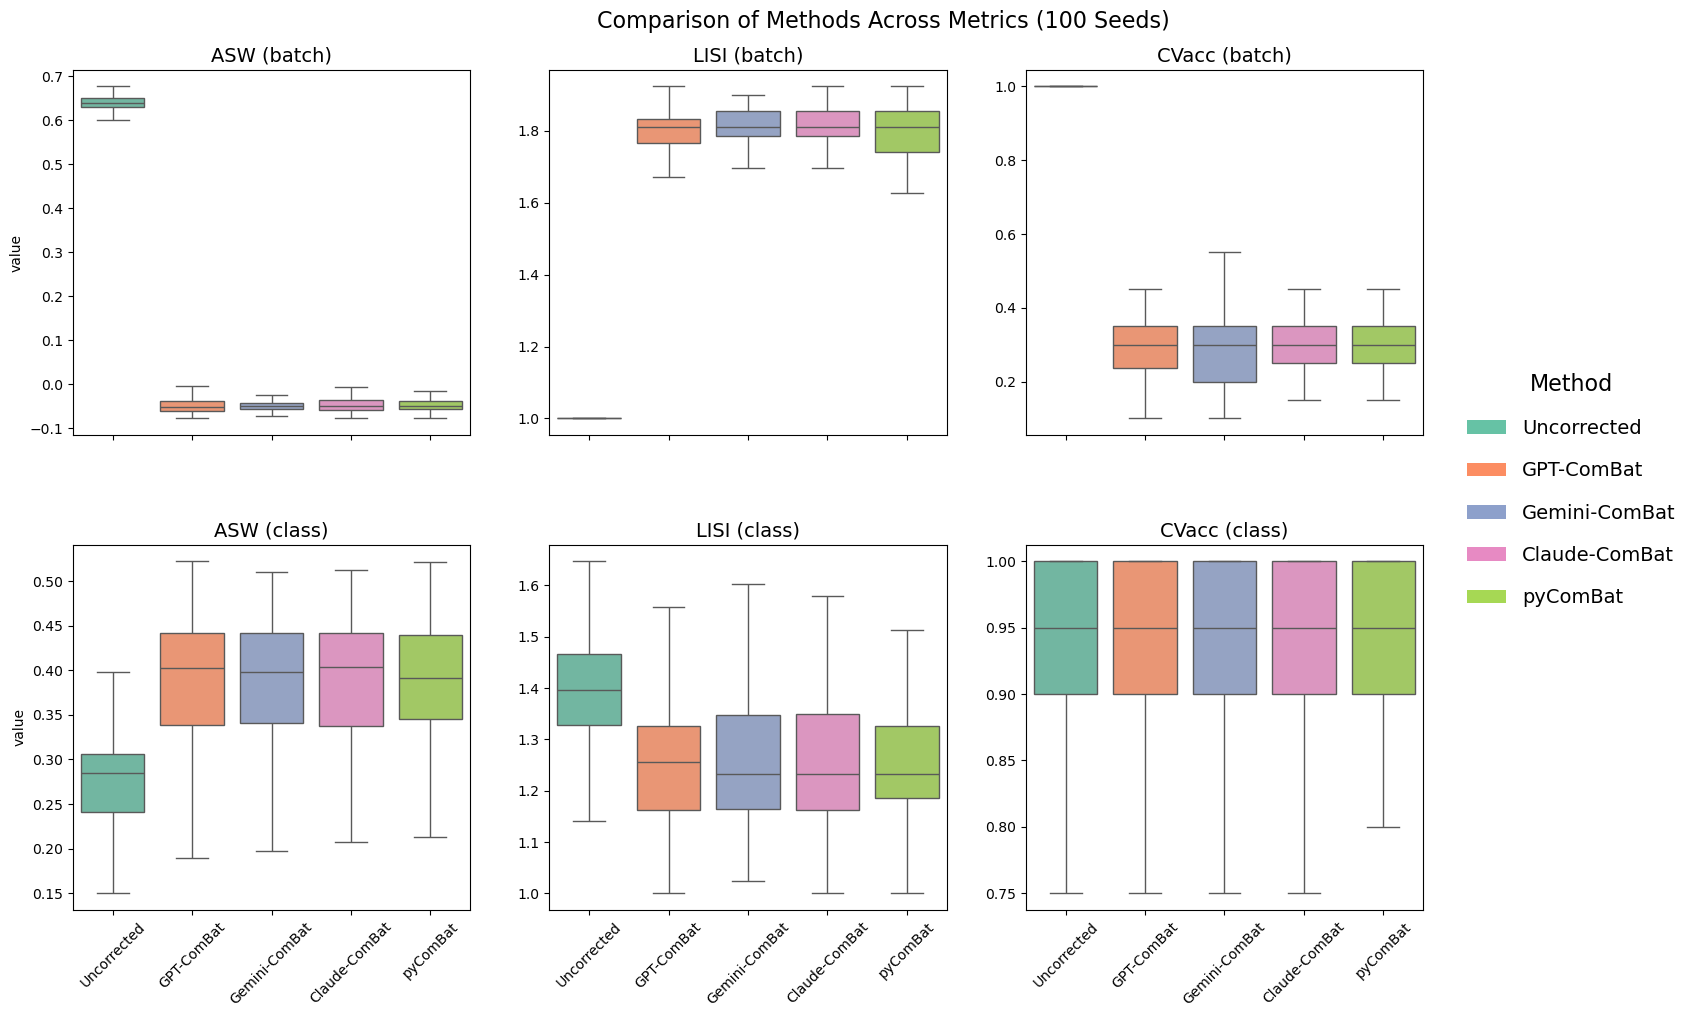

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# assume df_long, methods_order, palette, score_types, label_types are defined as before

fig, axes = plt.subplots(2, 3, figsize=(18,10), sharey=False)

for j, label in enumerate(label_types):
    for i, score in enumerate(score_types):
        ax = axes[j, i]
        sub = df_long[
            (df_long["ScoreType"] == score) &
            (df_long["LabelType"] == label)
        ]
        # boxplot with hue=method so palette is honored, legend disabled
        sns.boxplot(
            x="method", y="value",
            hue="method",
            data=sub,
            palette=palette,
            dodge=False,
            ax=ax,
            showfliers=False,
            legend=False
        )
        ax.set_title(f"{score} ({label})", fontsize=14)

        if j == 0:
            # top row: hide x‐axis labels
            ax.set_xlabel("")
            ax.tick_params(labelbottom=False)
        else:
            # bottom row: rotate the existing tick labels
            ax.set_xlabel("")
            ax.tick_params(axis='x', rotation=45, labelbottom=True)

        # only show y‐label on first column
        if i == 0:
            ax.set_ylabel("value")
        else:
            ax.set_ylabel("")

# shrink right side to make room for legend        
fig.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.08, hspace=0.3, wspace=0.2)

# single legend outside plotting area        
legend_handles = [Patch(facecolor=palette[m], label=m) for m in methods_order]
fig.legend(
    handles=legend_handles,
    title="Method",
    loc="center right",
    bbox_to_anchor=(0.95, 0.5),
    frameon=False,
    # ↑ these are the new sizing args ↓
    fontsize=14,           # legend text size
    title_fontsize=16,     # title text size
    markerscale=2,         # scale up the colored boxes
    handlelength=2,        # length of the legend patches
    labelspacing=1.2       # vertical space between entries
)

fig.suptitle("Comparison of Methods Across Metrics (100 Seeds)", fontsize=16)
plt.savefig('../plots/allmetrics-allmethods.svg', bbox_inches='tight')
plt.show()


In [12]:
# ASKING gpt whether it can make combat without pandas or numpy

In [13]:
import math

def combat_pure_python(data, batches):
    """
    Pure-Python ComBat batch correction (Johnson et al. 2007) without NumPy/Pandas.

    Parameters
    ----------
    data : list of list of float
        G×N matrix (G genes, N samples), so data[g][j] is gene g in sample j.
    batches : list
        length-N list of batch labels (one label per sample).

    Returns
    -------
    corrected : list of list of float
        G×N batch-corrected data.
    """
    epsilon = 1e-8
    G = len(data)
    if G == 0:
        return []
    N = len(batches)

    # 1) group sample indices by batch
    batch_indices = {}
    for j, b in enumerate(batches):
        batch_indices.setdefault(b, []).append(j)
    batches_unique = list(batch_indices.keys())
    n_i = {b: len(idxs) for b, idxs in batch_indices.items()}

    # Helpers
    def mean(lst):
        return sum(lst) / len(lst) if lst else 0.0
    def var(lst, ddof=0):
        n = len(lst)
        if n - ddof <= 0:
            return 0.0
        m = sum(lst)/n
        return sum((x-m)**2 for x in lst) / (n - ddof)

    # 2) Estimate α̂_g (per-gene mean) and center
    alpha_hat = [mean(row) for row in data]
    Yc = [[data[g][j] - alpha_hat[g] for j in range(N)] for g in range(G)]

    # 3) Estimate γ̂_ig (batch offset per gene)
    gamma_hat = {b: [0.0]*G for b in batches_unique}
    for b in batches_unique:
        idxs = batch_indices[b]
        for g in range(G):
            vals = [Yc[g][j] for j in idxs]
            gamma_hat[b][g] = mean(vals)

    # 4) Compute residuals R_ijg = Y_ijg - α̂_g - γ̂_ig
    residuals = [[0.0]*N for _ in range(G)]
    for g in range(G):
        for j in range(N):
            b = batches[j]
            residuals[g][j] = data[g][j] - alpha_hat[g] - gamma_hat[b][g]

    # 5) σ̂_g = sqrt( sum_j R_ijg^2 / N )
    sigma_hat = [
        math.sqrt(sum(residuals[g][j]**2 for j in range(N)) / N)
        for g in range(G)
    ]

    # 6) Standardize: Z = R / σ̂
    Z = [
        [(residuals[g][j] / (sigma_hat[g] if sigma_hat[g] != 0 else epsilon))
         for j in range(N)]
        for g in range(G)
    ]

    # 7) Estimate γ̂_{z,ig} and δ̂²_{ig} on Z
    gamma_hat_z = {b: [0.0]*G for b in batches_unique}
    delta_hat2  = {b: [0.0]*G for b in batches_unique}
    for b in batches_unique:
        idxs = batch_indices[b]
        ni = n_i[b]
        for g in range(G):
            vals = [Z[g][j] for j in idxs]
            mz = mean(vals)
            gamma_hat_z[b][g] = mz
            delta_hat2[b][g] = sum((v - mz)**2 for v in vals) / (ni if ni else 1)

    # 8) Fit priors (method of moments)
    gamma_bar = {}
    tau2      = {}
    lambda_   = {}
    theta     = {}
    for b in batches_unique:
        gz = gamma_hat_z[b]
        gb = mean(gz)
        gamma_bar[b] = gb
        t2 = var(gz, ddof=1)
        tau2[b] = t2 if t2 > epsilon else epsilon
        d2 = delta_hat2[b]
        m  = mean(d2)
        s2 = var(d2, ddof=1)
        s2 = s2 if s2 > epsilon else epsilon
        lam = 2.0 + (m*m / s2)
        lambda_[b] = lam
        theta[b]   = m * (lam - 1.0)

    # 9) Compute posteriors γ*_ig and δ*_{ig}
    gamma_star  = {b: [0.0]*G for b in batches_unique}
    delta_star  = {b: [0.0]*G for b in batches_unique}

    for b in batches_unique:
        idxs = batch_indices[b]
        ni  = n_i[b]
        tb  = tau2[b]
        gb  = gamma_bar[b]
        lb  = lambda_[b]
        th  = theta[b]
        for g in range(G):
            ghz = gamma_hat_z[b][g]
            d2  = delta_hat2[b][g]
            # additive term
            num = ni*tb*ghz + d2*gb
            den = ni*tb + d2
            gamma_star[b][g] = num / (den if den!=0 else epsilon)
            # multiplicative term
            ss = sum((Z[g][j] - gamma_star[b][g])**2 for j in idxs)
            ds2 = (th + 0.5*ss) / ((ni/2.0) + lb - 1.0)
            delta_star[b][g] = math.sqrt(ds2 if ds2>0 else epsilon)

    # 10) Adjust and back-transform
    corrected = [[0.0]*N for _ in range(G)]
    for g in range(G):
        for j in range(N):
            b = batches[j]
            # original standardized
            z = (data[g][j] - alpha_hat[g] - gamma_hat[b][g]) / \
                (sigma_hat[g] if sigma_hat[g]!=0 else epsilon)
            # remove shrunken batch effects
            za = (z - gamma_star[b][g]) / \
                 (delta_star[b][g] if delta_star[b][g]!=0 else epsilon)
            # back to original scale
            corrected[g][j] = za * sigma_hat[g] + alpha_hat[g]

    return corrected


In [14]:
%%capture

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

# make sure your pure‐Python ComBat is available in this namespace
# either define it above or import it:
# from your_module import combat_pure_python

# --- helpers ---
def compute_lisi(embedding, labels, k=5):
    n = embedding.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    _, idx = nbrs.kneighbors(embedding, return_distance=True)
    lisi = []
    for i in range(n):
        neigh = idx[i,1:]
        counts = np.bincount(labels[neigh], minlength=labels.max()+1)
        p = counts / counts.sum()
        lisi.append(1.0 / np.sum(p**2))
    return np.mean(lisi)

def classification_score(embedding, labels, random_state=0):
    clf = LogisticRegression(max_iter=200, solver='liblinear', random_state=random_state)
    cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    return cross_val_score(clf, embedding, labels, cv=cv).mean()

# --- methods mapping (now including Pure‐Python) ---
methods = {
    "Uncorrected":   lambda data, batch: data,
    "GPT-ComBat":    lambda data, batch: combat(data, batch),
    "Gemini-ComBat": lambda data, batch: combat_gemini(data, batch),
    "Claude-ComBat": lambda data, batch: combat_claude(data, batch),
    "pyComBat":      lambda data, batch: pycombat(data, batch=batch),
    "Pure-Python":   lambda data, batch: pd.DataFrame(
        combat_pure_python(data.values.tolist(), batch),
        index=data.index,
        columns=data.columns
    ),
}

# the metrics we'll compute
metric_names = [
    "ASW_class", "ASW_batch",
    "iLISI_batch", "cLISI_class",
    "CVacc_batch", "CVacc_class"
]

# initialize storage
results = {
    method: {met: [] for met in metric_names}
    for method in methods
}

# -- main loop over seeds --
for seed in range(100):
    # 1) generate your toy data (returns a DataFrame)
    data, batch_labels, class_labels = generate_toy_data(seed=seed)
    batch_arr = np.array(batch_labels)
    class_arr = np.array(class_labels)

    # 2) apply each method, PCA, then compute metrics
    for name, corr_fn in methods.items():
        mat = corr_fn(data, batch_labels)       # still a DataFrame (genes×samples)
        emb = PCA(n_components=2).fit_transform(mat.T.values)

        # silhouette (ASW)
        results[name]["ASW_class"].append( silhouette_score(emb, class_arr) )
        results[name]["ASW_batch"].append( silhouette_score(emb, batch_arr) )

        # LISI
        results[name]["iLISI_batch"].append( compute_lisi(emb, batch_arr, k=5) )
        results[name]["cLISI_class"].append( compute_lisi(emb, class_arr, k=5) )

        # CV accuracy
        results[name]["CVacc_batch"].append( classification_score(emb, batch_arr, random_state=seed) )
        results[name]["CVacc_class"].append( classification_score(emb, class_arr, random_state=seed) )

# After this you can flatten results into a DataFrame or plot directly
# e.g. to build a long‐form table:
records = []
for method, met_dict in results.items():
    for met, vals in met_dict.items():
        for v in vals:
            records.append({"method": method, "metric": met, "value": v})
df_long = pd.DataFrame.from_records(records)


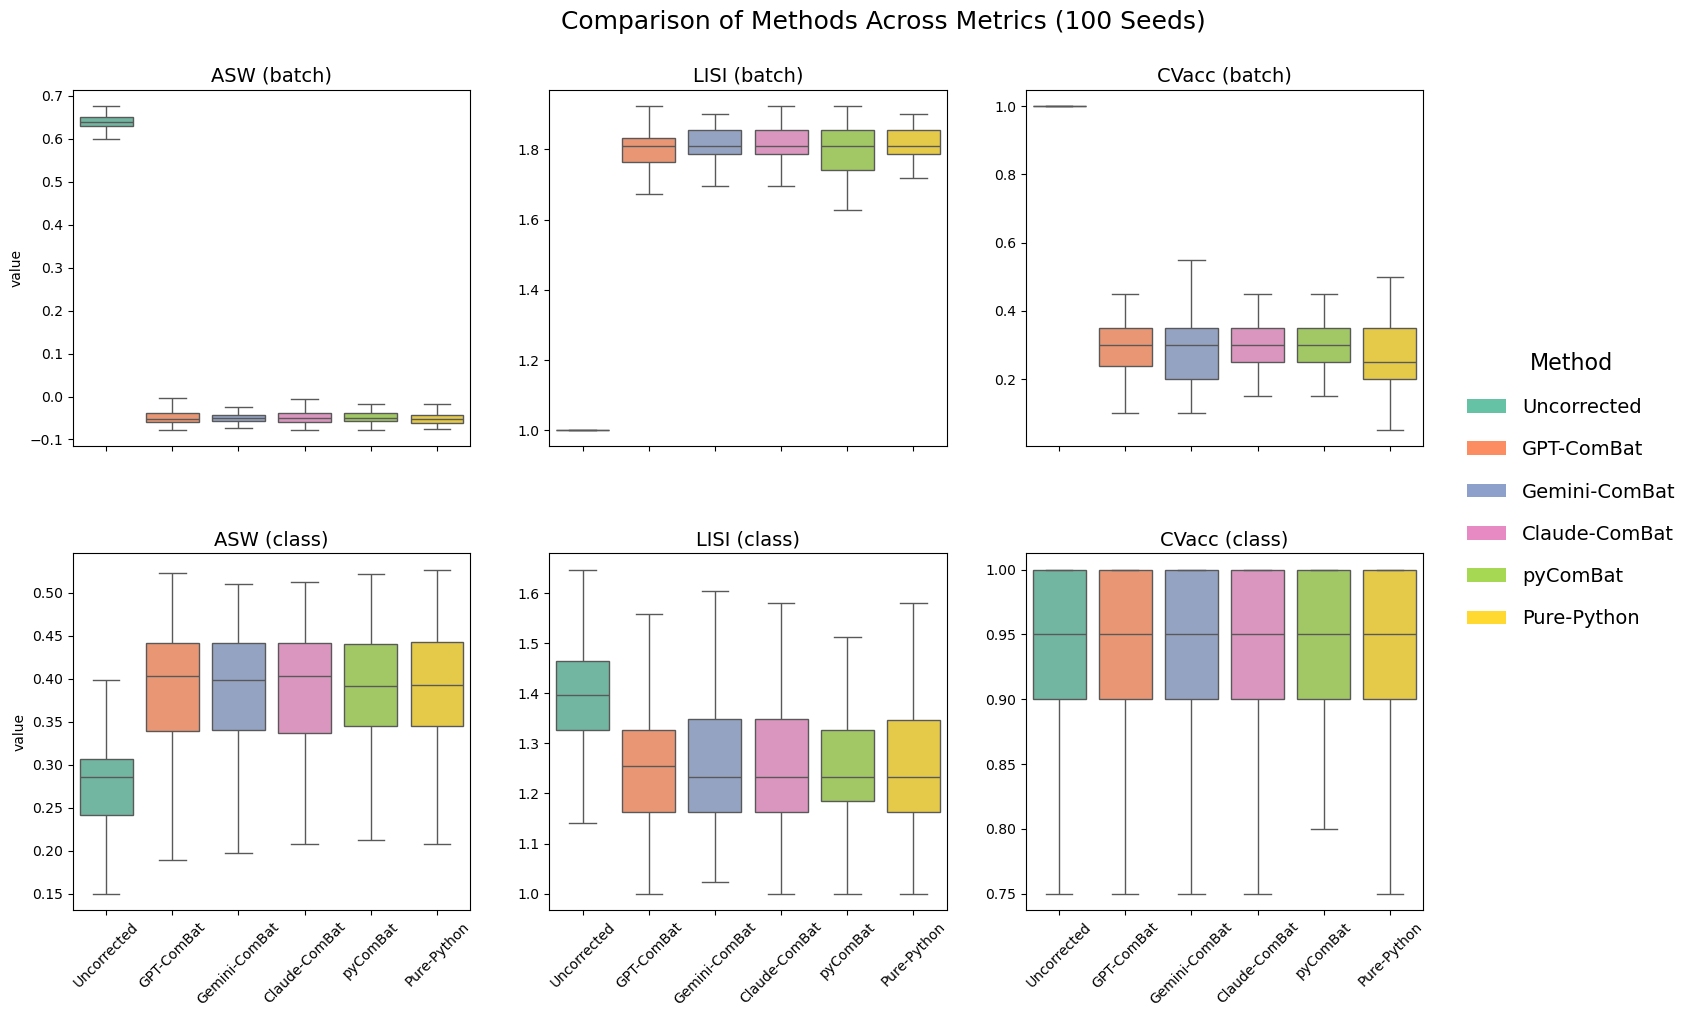

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# 1) If you haven’t already, parse your metric into ScoreType & LabelType
def _parse_metric(m):
    if m.startswith("ASW"):
        score = "ASW"
    elif m.startswith("iLISI") or m.startswith("cLISI"):
        score = "LISI"
    else:
        score = "CVacc"
    label = "batch" if m.endswith("_batch") else "class"
    return score, label

df_long[["ScoreType","LabelType"]] = df_long["metric"].apply(_parse_metric).tolist()

# 2) Define the order of methods and a consistent palette
methods_order = list(results.keys())  # e.g. ["Uncorrected", "GPT-ComBat", ..., "Pure-Python"]
palette = dict(zip(
    methods_order,
    sns.color_palette("Set2", n_colors=len(methods_order))
))

# 3) Set up the 2×3 grid
score_types = ["ASW","LISI","CVacc"]
label_types = ["batch","class"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

for row, label in enumerate(label_types):
    for col, score in enumerate(score_types):
        ax = axes[row, col]
        sub = df_long[
            (df_long.ScoreType == score) &
            (df_long.LabelType == label)
        ]
        sns.boxplot(
            x="method", y="value",
            hue="method", palette=palette, dodge=False,
            data=sub, order=methods_order,
            ax=ax, showfliers=False, legend=False
        )
        ax.set_title(f"{score} ({label})", fontsize=14)
        if row == 0:
            ax.tick_params(labelbottom=False)
        else:
            ax.tick_params(axis="x", rotation=45)
        if col != 0:
            ax.set_ylabel("")
        ax.set_xlabel("")

# 4) Shrink the right side to make room for the legend
fig.subplots_adjust(left=0.05, right=0.80, top=0.90, bottom=0.08, hspace=0.3, wspace=0.2)

# 5) Add a big legend outside
legend_handles = [Patch(facecolor=palette[m], label=m) for m in methods_order]
fig.legend(
    handles=legend_handles,
    title="Method",
    loc="center right",
    bbox_to_anchor=(0.95, 0.5),
    frameon=False,
    fontsize=14,
    title_fontsize=16,
    markerscale=2,
    handlelength=2,
    labelspacing=1.2
)

fig.suptitle("Comparison of Methods Across Metrics (100 Seeds)", fontsize=18)
plt.savefig('../plots/combat-metrics-purepy.svg', bbox_inches='tight')
plt.show()
